# High-Ram Validation

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.

# Lectura CSV

In [ ]:
import pandas as pd
df_spy = pd.read_csv('spy_options_call_output_all.csv')

In [ ]:
# Seleccionar solo ITM
df_spy = df_spy[df_spy['moneyness_category'] == 'ITM']

In [ ]:
# Ordenar cronológicamente el dataset
df_spy = df_spy.sort_values(by=['quote_date', 'expire_date'], ascending=True).reset_index(drop=True)

In [ ]:
# Verificar si esta ordenado correctamente
print(df_spy['quote_date'].head())
print(df_spy['quote_date'].tail())

0    2020-01-02
1    2020-01-02
2    2020-01-02
3    2020-01-02
4    2020-01-02
Name: quote_date, dtype: object
93162    2023-12-29
93163    2023-12-29
93164    2023-12-29
93165    2023-12-29
93166    2023-12-29
Name: quote_date, dtype: object


In [ ]:
df_spy.head()

,quote_date,expire_date,dte,underlying_last,strike,strike_distance,strike_distance_pct,c_last,c_bid,c_ask,...,relative_spread,dte_year,c_volume_log,c_volume_log_scaled,volume_zero,moneyness,iv_pct_rank,c_iv_min,iv_skew,spread_mid_price
0,2020-01-02,2020-01-08,6.0,324.87,317.0,7.9,0.024,7.86,7.85,7.93,...,0.010139,0.023810,3.526361,0.515994,0,1.024826,0.474359,0.07086,0.02496,0.010139
1,2020-01-02,2020-01-08,6.0,324.87,319.0,5.9,0.018,5.44,5.93,6.00,...,0.011735,0.023810,3.583519,0.524358,0,1.018401,0.384615,0.07086,0.01744,0.011735
2,2020-01-02,2020-01-08,6.0,324.87,320.0,4.9,0.015,4.94,4.95,5.02,...,0.014042,0.023810,4.317488,0.631756,0,1.015219,0.269231,0.07086,0.00780,0.014042
3,2020-01-02,2020-01-08,6.0,324.87,321.0,3.9,0.012,4.12,4.05,4.17,...,0.029197,0.023810,6.817831,0.997618,0,1.012056,0.294872,0.07086,0.00854,0.029197
4,2020-01-02,2020-01-10,8.0,324.87,280.0,44.9,0.138,40.85,44.81,44.98,...,0.003787,0.031746,1.791759,0.262179,0,1.160250,0.987179,0.07086,0.29953,0.003787


In [ ]:
df_spy.shape

(93167, 31)

# Features

In [ ]:
df_spy.groupby('anio').size()

,0
anio,
2020,23052
2021,28416
2022,17758
2023,23941


In [ ]:
# Test data
df_spy_2023 = df_spy[df_spy['anio'] == 2023]

In [ ]:
# Train data
df_spy = df_spy[df_spy['anio'] < 2023]

In [ ]:
# target_train = 'c_mid_price'
# target_test = 'c_last'
# MAE: 0.6235434835084429
# RMSE: 2.648048019022547
# R²: 0.9926071365933151

features_cols = [
                 # Variables Black Scholes (captura el comportamiento teorico del precio de la opcion)
                 'moneyness', # contiene a 'underlying_last' y 'strike'
                 'dte_year',
                 'c_iv',
                  # Variables que capturan micro-comportamientos del precio real de la opcion (utilizando 'c_mid_price' en periodo de entrenamiento)
                 'iv_skew',
                 'iv_pct_rank',
                 'c_volume_log_scaled', # volumen y liquidez
                 # Indicadores Greeks (aportan estructura del modelo BS)
                 'c_delta',
                 'c_gamma',
                 'c_vega',
                 'c_theta'
                  ]

Manten tu esquema:
- target_train = c_mid_price (mas estable al momento de entrenar)
- target_test = c_last (testear con valores reales del mercado)

Ese esquema es excelente y es exactamente lo que usan:
- market makers
- modelos basados en BS/Heston
- desk de volatilidad

In [ ]:
# target_train = 'c_last' # Para predecir el precio real transado de una opcion (Hacer un modelo robusto a mercado real, existe mucho mas ruido del mercado)
target_train = 'c_mid_price' # Para predecir (modelar) el precio teorico justo o replicar Black-Scholes
target_test = 'c_last'

In [ ]:
X = df_spy[features_cols]
y = df_spy[target_train]

In [ ]:
X_test_2023 = df_spy_2023[features_cols]
y_test_2023 = df_spy_2023[target_test]

In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


In [ ]:
X.describe()

,moneyness,dte_year,c_iv,iv_skew,iv_pct_rank,c_volume_log_scaled,c_delta,c_gamma,c_vega,c_theta
count,69226.000000,69226.000000,69226.000000,69226.000000,69226.000000,69226.000000,69226.000000,69226.000000,69226.000000,69226.000000
mean,1.102020,0.014043,0.584111,0.415515,0.539511,0.370145,0.891843,0.017429,0.062809,-0.187801
std,0.131762,0.010119,0.541251,0.535721,0.253356,0.246752,0.116625,0.038101,0.057160,0.169283
min,1.000022,0.000000,0.011770,-1.056210,0.001815,0.000000,0.056710,0.000000,0.000020,-0.999930
25%,1.026520,0.003968,0.236150,0.083513,0.333333,0.160059,0.863243,0.001990,0.020800,-0.254990
50%,1.058407,0.011905,0.373740,0.218820,0.534140,0.319921,0.938510,0.007760,0.043550,-0.138060
75%,1.120640,0.023810,0.724945,0.537397,0.753915,0.538615,0.965590,0.022500,0.087690,-0.065613
max,3.812400,0.031905,2.999450,2.961430,1.000000,1.000000,1.000000,1.603600,0.296900,-0.001620


In [ ]:
print(df_spy['moneyness_category'].value_counts())
print(df_spy['moneyness_category'].value_counts(normalize=True)*100)

moneyness_category
ITM    69226
Name: count, dtype: int64
moneyness_category
ITM    100.0
Name: proportion, dtype: float64


In [ ]:
y.describe()

,c_mid_price
count,69226.000000
mean,31.519181
std,30.969678
min,0.130000
25%,10.855000
50%,21.375000
75%,40.210000
max,281.265000


In [ ]:
print("cantidad features:", X.shape[1])
print("cantidad target:", len(y.shape))

cantidad features: 10
cantidad target: 1


In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


# Multi-Layer Perceptron (MLP)

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Split

In [ ]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y

# transformamos el target con log1p
y_train_log = np.log1p(y_train)

In [ ]:
y.describe()

,c_mid_price
count,69226.000000
mean,31.519181
std,30.969678
min,0.130000
25%,10.855000
50%,21.375000
75%,40.210000
max,281.265000


In [ ]:
y_train_log.describe()

,c_mid_price
count,69226.000000
mean,3.100331
std,0.890217
min,0.122218
25%,2.472750
50%,3.107944
75%,3.718681
max,5.642846


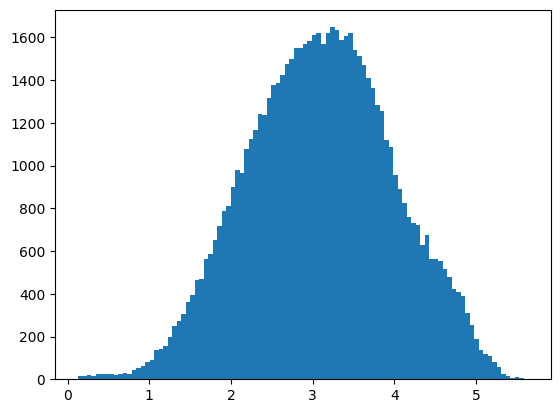

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_log, bins=100);

In [ ]:
print(f"Cantidad Registros para X_train: {X_train.shape[0]}")

Cantidad Registros para X_train: 69226


In [ ]:
print(f"Cantidad Registros para X_test_2023: {X_test_2023.shape[0]}")

Cantidad Registros para X_test_2023: 23941


## Escalar features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled  = scaler.transform(X_test)

X_test_2023_scaled = scaler.transform(X_test_2023)

## Construir modelo

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.activations import swish
import tensorflow as tf

In [ ]:
best_model = Sequential([
    Dense(256, activation=swish, input_shape=(X_train.shape[1],)),
    Dropout(0.15),

    Dense(128, activation=swish),
    BatchNormalization(),
    Dropout(0.10),

    Dense(64, activation=swish),

    Dense(32, activation=swish),

    Dense(1)  # precio
])

optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-5)

best_model.compile(optimizer=optimizer, loss='mse', metrics=[
        tf.keras.metrics.R2Score(name='r2')
    ])

best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 46,337 (181.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),

#     Dense(64, activation='relu'),
#     Dropout(0.2),

#     Dense(32, activation='relu'),

#     Dense(1)  # salida continua
# ])

# model.compile(optimizer='adam', loss='mse')
# model.summary()

## Entrenar modelo con los mejores hiperparametros

In [ ]:
start_time = time.time()

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_final = best_model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

end_time = time.time()
print(f"Training model time: {end_time - start_time} seconds")

Epoch 1/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.3853 - r2: -0.7664 - val_loss: 0.0318 - val_r2: 0.9416
Epoch 2/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0964 - r2: 0.8783 - val_loss: 0.0241 - val_r2: 0.9558
Epoch 3/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0579 - r2: 0.9269 - val_loss: 0.0213 - val_r2: 0.9609
Epoch 4/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0385 - r2: 0.9513 - val_loss: 0.0160 - val_r2: 0.9706
Epoch 5/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0306 - r2: 0.9614 - val_loss: 0.0208 - val_r2: 0.9618
Epoch 6/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0257 - r2: 0.9676 - val_loss: 0.0135 - val_r2: 0.9752
Epoch 7/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0216 - r2: 0.9731 - val_loss: 0.0134 - val_r2: 0.9754
Epoch 8/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0194 - r2: 0.9757 - val_loss: 0.0106 - val_r2: 0.9805
Epoch 9/200
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.

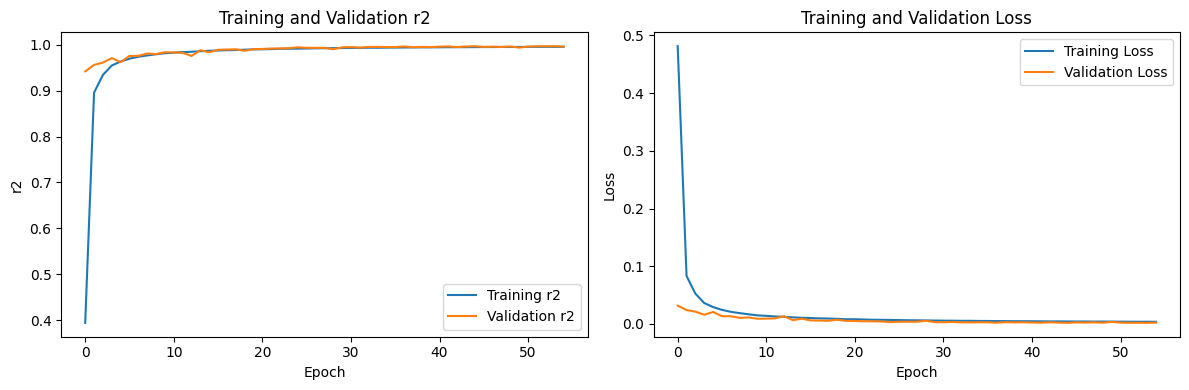

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['r2'], label='Training r2')
plt.plot(history_final.history['val_r2'], label='Validation r2')
plt.title('Training and Validation r2')
plt.xlabel('Epoch')
plt.ylabel('r2')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Backtesting

### Total

In [ ]:
start_time = time.time()

y_pred_log_best = best_model.predict(X_test_2023_scaled).flatten()

end_time = time.time()
print(f"Backtesting time: {end_time - start_time} seconds")

749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Backtesting time: 1.348607063293457 seconds


In [ ]:
# Destransformar predicciones
y_pred_best = np.expm1(y_pred_log_best)

In [ ]:
print("MAE:", mean_absolute_error(y_test_2023, y_pred_best))
print("RMSE:", mean_squared_error(y_test_2023, y_pred_best))
print("R²:", r2_score(y_test_2023, y_pred_best))

MAE: 1.1201548464538273
RMSE: 5.345011048232667
R²: 0.9886347351547788


### Por Q

In [ ]:
#Dar formato fecha
df_spy_2023['quote_date'] = pd.to_datetime(df_spy_2023['quote_date'])

In [ ]:
quarters = [(1, 3), (4, 6), (7, 9), (10, 12)]
q = 1
for quarter in quarters:
    start_month, end_month = quarter
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        ((df_spy_2023['quote_date'].dt.month >= start_month) & (df_spy_2023['quote_date'].dt.month <= end_month))
    )
    # Features
    df_spy_2023_q = df_spy_2023[conditions]
    X_test_2023_q = df_spy_2023_q[features_cols]
    X_test_2023_q_scaled = scaler.transform(X_test_2023_q)

    # Target
    y_test_2023_q = df_spy_2023_q[target_test]

    # Predecir
    y_pred_log_best_q = best_model.predict(X_test_2023_q_scaled)

    # Destransformar predicciones
    y_pred_best_q = np.expm1(y_pred_log_best_q)

    print(f"***** Backtesting Q{q} *****")
    print("MAE:", mean_absolute_error(y_test_2023_q, y_pred_best_q))
    print("RMSE:", mean_squared_error(y_test_2023_q, y_pred_best_q))
    print("R²:", r2_score(y_test_2023_q, y_pred_best_q))
    print()
    q += 1

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Q1 *****
MAE: 1.2067079274414965
RMSE: 5.555575467446498
R²: 0.9785170316160388

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Q2 *****
MAE: 0.9245423571560921
RMSE: 3.533871795163894
R²: 0.9905527539437574

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Q3 *****
MAE: 1.301412218642818
RMSE: 6.222996074782686
R²: 0.9913022966281201

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Q4 *****
MAE: 0.997089568803774
RMSE: 5.926969498942865
R²: 0.9849569133687514



### Por Mes

In [ ]:
m = 1
for month in range(1, 13):
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        (df_spy_2023['quote_date'].dt.month == month)
    )
    # Features
    df_spy_2023_m = df_spy_2023[conditions]
    X_test_2023_m = df_spy_2023_m[features_cols]
    X_test_2023_m_scaled = scaler.transform(X_test_2023_m)

    # Target
    y_test_2023_m = df_spy_2023_m[target_test]

    # Predecir
    y_pred_log_best_m = best_model.predict(X_test_2023_m_scaled)

    # Destransformar predicciones
    y_pred_best_m = np.expm1(y_pred_log_best_m)

    print(f"***** Backtesting Mes {m} *****")
    print("MAE:", mean_absolute_error(y_test_2023_m, y_pred_best_m))
    print("RMSE:", mean_squared_error(y_test_2023_m, y_pred_best_m))
    print("R²:", r2_score(y_test_2023_m, y_pred_best_m))
    print()
    m += 1

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
***** Backtesting Mes 1 *****
MAE: 1.026714638936617
RMSE: 3.7049574850987312
R²: 0.983297189610073

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
***** Backtesting Mes 2 *****
MAE: 1.316609403890653
RMSE: 7.3687284470102385
R²: 0.973154578120632

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Mes 3 *****
MAE: 1.2855917526404526
RMSE: 5.705720135290701
R²: 0.9796490241172111

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
***** Backtesting Mes 4 *****
MAE: 0.863018491470143
RMSE: 2.780896065772058
R²: 0.9910263615565579

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Mes 5 *****
MAE: 0.9560338792915385
RMSE: 3.6023394875828396
R²: 0.989904244242879

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Mes 6 *****
MAE: 0.9372315528847521
RMSE: 4.042314072746061
R²: 0.9906823960128994

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
***** Backtesting Mes 7 *****
MAE: 1.3186536751804387
RMSE: 5.504935317424642
R²: 0.9910087116249408

95/95 ━━━━━━

## Graficas

In [ ]:
pip install scikeras

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin

# Custom wrapper for the already trained Keras model
class KerasTrainedModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        # Store the trained Keras model
        self.model = model

    def predict(self, X):
        # Keras predict often returns a 2D array, flatten for compatibility with sklearn metrics
        # Also need to inverse transform the predictions (expm1) as the model predicts on log-transformed target
        log_predictions = self.model.predict(X).flatten()
        return np.expm1(log_predictions)

    def score(self, X, y_true):
        # Calculate R2 score using the inverse-transformed predictions
        y_pred = self.predict(X)
        return r2_score(y_true, y_pred)

    # The fit method is required by BaseEstimator, but for an already trained model, it can be a no-op
    def fit(self, X, y=None):
        return self

    # This property makes the wrapper recognizable as a regressor by scikit-learn utilities
    @property
    def _estimator_type(self):
        return "regressor"

    # Removed __sklearn_tags__ to avoid conflict with _estimator_type in some sklearn versions.
    # The _estimator_type property is sufficient for identifying as a regressor.

# Instantiate the wrapper with your trained Keras model
model_wrapped = KerasTrainedModelWrapper(best_model)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_wrapped,
    X_test_2023_scaled, # Use the scaled test data for 2023
    y_test_2023,        # Use the actual test target for 2023
    n_repeats=10,
    random_state=42,
    scoring="r2"       # Use R² as the scoring metric
)

importance_mean = result.importances_mean
importance_std  = result.importances_std

df_importance = pd.DataFrame({
    "feature": features_cols,
    "importance": importance_mean,
    "std": importance_std
}).sort_values("importance", ascending=False)

749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
749/749 ━━━━━━━━

In [ ]:
df_importance

,feature,importance,std
8,c_vega,273.871100,320.695790
6,c_delta,28.564911,24.559426
2,c_iv,20.442791,6.733945
7,c_gamma,0.249054,0.002813
0,moneyness,0.188091,0.005361
3,iv_skew,0.179793,0.003841
1,dte_year,0.013987,0.000714
9,c_theta,0.012051,0.000731
4,iv_pct_rank,0.006591,0.000239
5,c_volume_log_scaled,0.000936,0.000116


In [ ]:
importances = pd.Series(df_importance.importance.values, index=df_importance.feature)
importances.sort_values(ascending=False)

,0
feature,
c_vega,273.871100
c_delta,28.564911
c_iv,20.442791
c_gamma,0.249054
moneyness,0.188091
iv_skew,0.179793
dte_year,0.013987
c_theta,0.012051
iv_pct_rank,0.006591


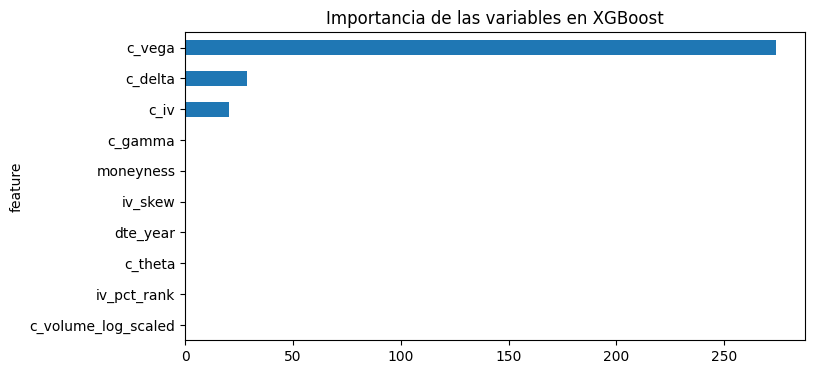

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(df_importance.importance.values, index=df_importance.feature)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 4))
plt.title("Importancia de las variables en XGBoost")
plt.show()

## Conclusiones

- R² ≈ 99.26% → el modelo generaliza bien.
- La variable con mayor importancia en el modelo es moneyness.
- Las relaciones en 2023 siguen el comportamiento historico de los 3 ultimos años, el modelo se adapta bien.
- moneyness domina → correcto (S/K controla la convexidad del payoff).
- delta fuerte → correcto (afecta sensibilidad del precio de la opcion respecto al precio del subyacente).
- skew, theta, vega → capturan micro-comportamientos.

**Los resultados del modelo:**
- MAE ≈ 0.62
  - Esto significa que en promedio el modelo se equivoca 62 dólares por contrato (≈ 0.62, sesenta y dos centavos por prima), lo cual es poco eficiente en general.
- RMSE ≈ 2.65
- R² ≈ 0.9926
  - Esto indica que el modelo explica gran parte de la variabilidad del precio.

Sí es razonable para opciones americanas SPY (mucha microestructura, volatilidad, saltos).
- *Incluso los market makers profesionales trabajan con errores absolutos similares cuando no usan el order book directo. SIN EMBARGO, INTERPRETACION:

- **MAE** = 0.6235 -> **En prima:** Error promedio de 62 centavos -> **En contrato  (×100):** Error promedio de $62.35.

- **RMSE** = 2.65 -> **En prima:** Error típico grande de 2.65 dolares -> **En contrato  (x100):** Error promedio de $265 por contrato.

**Conclusion**
- Los resultados de MAE y RMSE son aceptables si el objetivo es determinar el valor Teorico de la opcion (prima).
- El modelo explica gran parte de la variabilidad del precio, pero es ineficiente al momento de determinar el precio real de una opcion.


- Si el **Objetivo es determinar el valor Real de la opcion (prima)** el MAE deberia ser <= 0.10 (10 centavos de dolar en valor de la prima). Ojo esto Difícil pero no imposible llegar a ese MAE, Actualmente no hay modelos que lleguen a ese nivel tan bajo de MAE.

**A nivel académico:***
- Modelos de deep learning de última generación (LSTMs, Transformers, DNN + LSV):
  - MAE ≈ 0.20–0.40 sobre el mid price.
- Sobre last price:
  - MAE ≈ 0.40–1.20

**En bancos y market makers (información no pública pero estandarizada):**
- Para activos muy líquidos (SPY, QQQ):
  - MAE ~ 0.15–0.40 sobre mid
  - MAE ~ 0.30–1.00 sobre last

**Menos líquido:**
- MAE > 1.0 es normal.

**MI HIPOTESIS (PROBARLO):**
- Como pienso aplicar swing-trading (periodos cortos de 3 a 9 dias de trading), podria probar eliminando precios (primas iliquidas), probar entrenar modelo por ITM (menos liquidez) y el mismo modelos pero solo con OTM (mas liquidez).

**Predomina la feature moneyness porque:**

De hecho, de acuerdo al modelo de Black-Scholes:

**Black-Scholes** = f(S,K,T, sigma, r)

- S = Subyacent price
- K = Strike
- T = dte_year
- sigma = c_iv
- r (tasa libre de riesgo) = se puede ignorar para opciones ultracortas.

**Features Optimos del modelo:**
- **moneyness** = S / K
- **dte_year** = T (tiempo de vencimiento en escala de un año)
- **c_iv** = sigma

In [ ]:
# Finished!